## visualization

This notebook contains the data manipulation steps required for the visualization elements across the web platform. Some visualization components were replicated here to facilitate reading, for further explanation of visualization elements on the site see d3.js documentation.

All data in the website is available from public access sources (see CNED, SNED and JUNAEB websites), with exception of the simulated invididual level data (mn2017). For further discussion of the simulated data see the methods Notebook. 

### housekeeping

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import json
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# higher ed data
cned = pd.read_csv('../data/cned/cned.csv')
# school performance data
sned = pd.read_csv('../data/sned/sned.csv')
# junaeb school data
mn = pd.read_csv('../data/mn/1m2017.csv')
# school geodata
geoData = pd.read_csv('../data/geo/geo_rbd.csv')
# individual level simulated data
mn2017 = pd.read_csv('../data/mn/mn_5p_2017b.csv')

cned.dropna(inplace=True)
sned.dropna(inplace=True)
mn.dropna(inplace=True)
# geoData.dropna(inplace=True)

### enrollment and stanzarized entry scores for higher ed programs

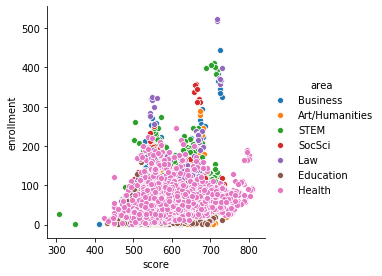

In [3]:
# change plot size
cned.rename(columns={"puntaje": "score", "ingreso2": "enrollment"}, inplace=True)
scatter1 = sns.pairplot(x_vars="score", y_vars="enrollment", data=cned, hue="area", height=4)


In [4]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)

In [5]:
# create json data
jsonData = cned[['idc','enrollment', 'score', 'area', 'year']].groupby(by='year').apply(lambda x: x.to_dict('records'))
dataYearsList = cned['year'].unique()

# create an output json variable
output = []
i = 0
while i<len(dataYearsList):
#     print(i, dataYearsList[i])
    outputObject = {}
    outputObject['year'] = dataYearsList[i]
    outputObject['areas'] = jsonData.iloc[i]
    output.append(outputObject)
    i = i+1

In [6]:
output
# print(output.to_json())
jsonDump = json.dumps(output, cls=NpEncoder)
# print(json.loads(jsonDump))
# print(json.loads(jsonOutput))
jsonOutput = json.loads(jsonDump)

In [7]:
with open('../data/viz/output.json', 'w') as outfile:
    json.dump(jsonOutput, outfile)

### obesity prevalence and school performance

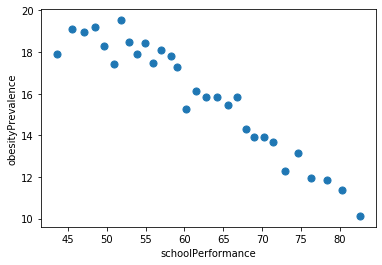

In [8]:
mn.dropna(inplace=True)
mn['obesityPrevalence'] = ((mn['onino'] + mn['onina']) / mn['total']) * 100
mn.set_index('idrbd')
mn['idrbd'] = mn['idrbd'].astype(np.int64)
sned.rename(columns={"efectivr": "schoolPerformance"}, inplace=True)
mergedData = pd.merge(mn, sned, on='idrbd', how='inner')

#scatterplot
#plt.scatter(mergedData['schoolPerformance'], mergedData['obesityPrevalence'])

#binned scatterplot
bin1 = sns.regplot('schoolPerformance', 'obesityPrevalence', 
            data=mergedData, x_bins=30, ci=None, fit_reg=False)

#bin1.savefig("bin1.png")

### Geodata visualization

In [9]:
#geodata visualization
geoData.duplicated().value_counts()

False    16024
dtype: int64

In [10]:
mn['idrbd'].duplicated().value_counts()

False    2480
Name: idrbd, dtype: int64

In [11]:
mergedGeo = pd.merge(mn, geoData, on='idrbd', how='outer')

In [12]:
mergedGeo[['idrbd', 'LATITUD']].isna()['LATITUD'].value_counts()

False    12536
True      3488
Name: LATITUD, dtype: int64

In [13]:
geoData.columns

Index(['year', 'idrbd', 'DGV_RBD', 'NOM_RBD', 'MRUN', 'RUT_SOSTENEDOR',
       'P_JURIDICA', 'COD_REG_RBD', 'COD_PRO_RBD', 'COD_COM_RBD',
       'NOM_COM_RBD', 'COD_DEPROV_RBD', 'NOM_DEPROV_RBD', 'COD_DEPE',
       'COD_DEPE2', 'RURAL_RBD', 'LATITUD', 'LONGITUD', 'CONVENIO_PIE',
       'ENS_01', 'ENS_02', 'ENS_03', 'ENS_04', 'ENS_05', 'ENS_06', 'ENS_07',
       'ENS_08', 'ENS_09', 'MATRICULA', 'ESTADO_ESTAB', 'ORI_RELIGIOSA',
       'ORI_OTRO_GLOSA', 'PAGO_MATRICULA', 'PAGO_MENSUAL'],
      dtype='object')

In [14]:
mergedGeo['idrbd'].duplicated().value_counts()
mergedGeoSubset = mergedGeo[['idrbd', 'LATITUD', 'LONGITUD', 'NOM_RBD', 'NOM_COM_RBD', 'NOM_DEPROV_RBD']]

In [15]:
mergedGeoSubset.dropna(inplace=True)
mergedGeoSubset.reset_index(drop=True, inplace=True)

/home/alberto/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
mergedGeoSubset['LONGITUD'][5003]

'-70,58'

In [17]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)

In [18]:
geojson = {
    "type": 'FeatureCollection',
}
features = []
i = 0

while i < len(mergedGeoSubset):
#     print(mergedGeo['LATITUD'][i])
#     if mergedGeo['LATITUD'][i] != -9 and mergedGeo['LONGITUD'][i] != -9:
    longitude = (mergedGeoSubset['LONGITUD'][i][:3] + '.' + mergedGeoSubset['LONGITUD'][i][3:]).replace(',', '')
    latitude = (mergedGeoSubset['LATITUD'][i][:3]+ '.' + mergedGeoSubset['LATITUD'][i][3:]).replace(',', '')
    
    featureObject = {
        "type": "Feature",
        "geometry": {
            "type": "Point",
            "coordinates": [ float(longitude), float(latitude) ]
        },
        "properties": {
            "schoolName": mergedGeoSubset['NOM_RBD'][i],
            "community": mergedGeoSubset['NOM_COM_RBD'][i],
            "province": mergedGeoSubset['NOM_DEPROV_RBD'][i]
        }
    }
    features.append(featureObject)
    i=i+1
    
geojson['features'] = features


In [19]:
geojson['features'][5003]

{'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [-70.58, -33.453592]},
 'properties': {'schoolName': 'COLEGIO LA FONTAINE',
  'community': '�U�OA',
  'province': 'SANTIAGO ORIENTE'}}

In [20]:
jsonDump = json.dumps(geojson, cls=NpEncoder)
jsonOutput = json.loads(jsonDump)

In [21]:
with open('../data/viz/geoOutput.json', 'w') as outfile:
    json.dump(jsonOutput, outfile)

In [22]:
# explore employment data for mn2017 variable
occu_index = mn2017['ocu_padre_0'].value_counts(normalize=True).index
mn2017['ocu_padre_0'].value_counts(normalize=True)

4.0     0.400000
12.0    0.172046
3.0     0.127722
2.0     0.093900
5.0     0.091274
1.0     0.088494
9.0     0.010811
11.0    0.008185
8.0     0.003398
10.0    0.003089
7.0     0.000618
6.0     0.000463
Name: ocu_padre_0, dtype: float64

In [23]:
occu_index

Float64Index([4.0, 12.0, 3.0, 2.0, 5.0, 1.0, 9.0, 11.0, 8.0, 10.0, 7.0, 6.0], dtype='float64')

In [24]:
# calculate percent of people employed 
i = 0
mn2017['employedDad'] = 0
while i < len(mn2017['ocu_padre_0']):    
    if mn2017['ocu_padre_0'][i] > 8:
        mn2017['employedDad'][i] = 0
    else:
        mn2017['employedDad'][i] = 1
    i = i+1    

/home/alberto/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/alberto/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
# calculate percent of people employed 
i = 0
mn2017['employedMom'] = 0
while i < len(mn2017['ocu_madre_0']):    
    if mn2017['ocu_madre_0'][i] > 8:
        mn2017['employedMom'][i] = 0
    else:
        mn2017['employedMom'][i] = 1
    i = i+1    

/home/alberto/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/alberto/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
mn2017['employedMom'].value_counts(normalize=True)

1    0.57091
0    0.42909
Name: employedMom, dtype: float64

In [27]:
mn2017['employedDad'].value_counts(normalize=True)

1    0.809747
0    0.190253
Name: employedDad, dtype: float64

In [28]:
mn2017['imce_1'].mean()

1.041740578428606

In [29]:
variablesToMean = ['imce_0', 'imce_1', 'imce_2', 'te_0', 'te_1', 'te_2', 'I1', 'I2', 'S0', 'S1', 'S2', 'employedDad', 'employedMom']

for var in variablesToMean:
    mn2017[var + 'Mean'] = mn2017[var].mean()

mn2017.rename(columns= {"rbd_0": "idrbd"}, inplace=True)

In [30]:
mnBySchool = mn2017.groupby(by='idrbd', sort=True)

In [31]:
employmentVariables = ['employedMom', 'employedDad']

employedData = {}
rbdMoms = []
rbdDads = []
for var in employmentVariables:    
    indices = mnBySchool[var].value_counts(normalize=True).index
    employed =  mnBySchool[var].value_counts(normalize=True)

    employedMean = []

    i = 0
    while i < len(mnBySchool[var].value_counts()):
        if indices[i][1] == 1:
            employedMean.append(employed[i])
            if var == 'employedMom':
                rbdMoms.append(indices[i][0])
            else:
                rbdDads.append(indices[i][0])
        i = i+1
    
    employedData[var] = employedMean

employedData['idrbdMom'] = rbdMoms
employedData['idrbdDad'] = rbdDads

employedMomsDf = pd.DataFrame({'idrbd': employedData['idrbdMom'], 'employedMom': employedData['employedMom']})
employedDadsDf = pd.DataFrame({'idrbd': employedData['idrbdDad'], 'employedDad': employedData['employedDad']})
employedDf = employedMomsDf.merge(employedDadsDf, how='inner', on='idrbd')
# len(employedMean)

# calculate perc


In [32]:
dataBySchool = {
    'idrbd': list(mnBySchool.mean().index),
    'familySize': list(mnBySchool['n_personas_0'].mean().round(2))
}

i = 0
while i < len(variablesToMean):
    dataBySchool[variablesToMean[i]] = list(mnBySchool[variablesToMean[i]].mean())
    dataBySchool[variablesToMean[i] + 'Mean'] = mn2017[variablesToMean[i]].mean()
    i = i+1
    
print(dataBySchool.keys())

dict_keys(['idrbd', 'familySize', 'imce_0', 'imce_0Mean', 'imce_1', 'imce_1Mean', 'imce_2', 'imce_2Mean', 'te_0', 'te_0Mean', 'te_1', 'te_1Mean', 'te_2', 'te_2Mean', 'I1', 'I1Mean', 'I2', 'I2Mean', 'S0', 'S0Mean', 'S1', 'S1Mean', 'S2', 'S2Mean', 'employedDad', 'employedDadMean', 'employedMom', 'employedMomMean'])


In [33]:
bySchoolDf = pd.DataFrame(dataBySchool)

bySchoolDf.dropna(inplace=True)
bySchoolDf

,idrbd,familySize,imce_0,imce_0Mean,imce_1,imce_1Mean,imce_2,imce_2Mean,te_0,te_0Mean,...,S0,S0Mean,S1,S1Mean,S2,S2Mean,employedDad,employedDadMean,employedMom,employedMomMean
0,4160,4.87,0.992667,1.082676,0.748000,1.041741,0.750667,1.025924,-0.013333,0.337282,...,-0.016670,0.134862,0.054049,0.122699,-0.017343,0.130974,0.733333,0.809747,0.666667,0.57091
1,4168,5.00,0.373333,1.082676,-0.110000,1.041741,0.636667,1.025924,1.226667,0.337282,...,-0.236755,0.134862,0.214338,0.122699,0.028673,0.130974,0.333333,0.809747,0.000000,0.57091
2,4169,4.90,1.165909,1.082676,1.708182,1.041741,0.863182,1.025924,0.300909,0.337282,...,0.238514,0.134862,0.300232,0.122699,0.260349,0.130974,0.863636,0.809747,0.727273,0.57091
3,4171,5.14,1.282857,1.082676,1.327143,1.041741,1.198571,1.025924,0.205714,0.337282,...,0.244018,0.134862,-0.026305,0.122699,0.054147,0.130974,0.857143,0.809747,0.285714,0.57091
4,4172,4.10,0.642000,1.082676,0.974000,1.041741,0.796000,1.025924,0.536000,0.337282,...,0.292802,0.134862,0.300619,0.122699,0.324179,0.130974,0.800000,0.809747,0.600000,0.57091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,31107,3.73,0.618182,1.082676,0.959091,1.041741,0.709091,1.025924,0.657273,0.337282,...,0.299403,0.134862,0.340071,0.122699,0.280056,0.130974,0.545455,0.809747,0.181818,0.57091
456,31110,3.90,1.147619,1.082676,1.274286,1.041741,0.861429,1.025924,0.343810,0.337282,...,0.103572,0.134862,0.126774,0.122699,0.167525,0.130974,0.904762,0.809747,0.809524,0.57091
457,31119,3.87,1.089474,1.082676,1.050526,1.041741,1.132632,1.025924,0.438684,0.337282,...,0.355419,0.134862,0.362070,0.122699,0.323160,0.130974,0.973684,0.809747,0.894737,0.57091
458,31121,4.23,0.732308,1.082676,0.579231,1.041741,0.043846,1.025924,-0.053846,0.337282,...,0.016162,0.134862,-0.003002,0.122699,0.198354,0.130974,0.692308,0.809747,0.230769,0.57091


In [34]:
mn2017Geo = mergedGeoSubset.merge(bySchoolDf, how='inner', on='idrbd')

mn2017Geo.columns

Index(['idrbd', 'LATITUD', 'LONGITUD', 'NOM_RBD', 'NOM_COM_RBD',
       'NOM_DEPROV_RBD', 'familySize', 'imce_0', 'imce_0Mean', 'imce_1',
       'imce_1Mean', 'imce_2', 'imce_2Mean', 'te_0', 'te_0Mean', 'te_1',
       'te_1Mean', 'te_2', 'te_2Mean', 'I1', 'I1Mean', 'I2', 'I2Mean', 'S0',
       'S0Mean', 'S1', 'S1Mean', 'S2', 'S2Mean', 'employedDad',
       'employedDadMean', 'employedMom', 'employedMomMean'],
      dtype='object')

In [35]:
geojson = {
    "type": 'FeatureCollection',
}
features = []
i = 0

while i < len(mn2017Geo):
#     print(mergedGeo['LATITUD'][i])
#     if mergedGeo['LATITUD'][i] != -9 and mergedGeo['LONGITUD'][i] != -9:
    longitude = (mn2017Geo['LONGITUD'][i][:3] + '.' + mn2017Geo['LONGITUD'][i][3:]).replace(',', '')
    latitude = (mn2017Geo['LATITUD'][i][:3]+ '.' + mn2017Geo['LATITUD'][i][3:]).replace(',', '')
    
    featureObject = {
        "type": "Feature",
        "geometry": {
            "type": "Point",
            "coordinates": [ float(longitude), float(latitude) ]
        },
        "properties": {
            "schoolName": mergedGeoSubset['NOM_RBD'][i],
            "community": mergedGeoSubset['NOM_COM_RBD'][i],
            "province": mergedGeoSubset['NOM_DEPROV_RBD'][i]
        }
    }
    
    j = 0
    while j < len(mn2017Geo.columns):
        featureObject['properties'][mn2017Geo.columns[j]] = mn2017Geo[mn2017Geo.columns[j]][i]
        j = j+1
    
    features.append(featureObject)
    i=i+1
    
geojson['features'] = features


In [36]:
geojson['features'][0]

{'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [-73.07382639, -36.80922772]},
 'properties': {'schoolName': 'INST. COM. DE IQUIQUE BALDOMERO WOLNITZKY',
  'community': 'IQUIQUE',
  'province': 'IQUIQUE',
  'idrbd': 4531,
  'LATITUD': '-3680922772',
  'LONGITUD': '-7307382639',
  'NOM_RBD': 'COLEGIO MARINA DE CHILE',
  'NOM_COM_RBD': 'CONCEPCION',
  'NOM_DEPROV_RBD': 'CONCEPCION',
  'familySize': 4.58,
  'imce_0': 1.0749999801666665,
  'imce_0Mean': 1.0826759498331466,
  'imce_1': 1.7870833129583337,
  'imce_1Mean': 1.041740578428606,
  'imce_2': 0.9062499803750002,
  'imce_2Mean': 1.0259240201925535,
  'te_0': 0.7633333308333333,
  'te_0Mean': 0.3372816704912366,
  'te_1': 0.32833332675,
  'te_1Mean': 0.26692598558879976,
  'te_2': 0.4383333374500001,
  'te_2Mean': 0.16498864843405478,
  'I1': 0.07125152510416669,
  'I1Mean': 0.004636580569999546,
  'I2': 0.14118989807833335,
  'I2Mean': 0.004829786236223506,
  'S0': 0.18647305554166668,
  'S0Mean': 0.134862136100582

In [37]:
jsonDump = json.dumps(geojson, cls=NpEncoder)
jsonOutput = json.loads(jsonDump)

In [38]:
with open('../data/viz/mn2017geoOutput.json', 'w') as outfile:
    json.dump(jsonOutput, outfile)

# Boxplot data processing

The following cells will go over preparing data to be presented as a boxplot on the frontend.

Ultimately we are interested in creating a dataframe with the following columns:

- BAZ: Weight for Age Z-score
- HAZ: Height for Age Z-score
- Socioemotional Skills
- Birth Weight
- Grade
- Sex

In [39]:
mn2017

,sexo_0,idrbd,te_0,imce_0,vive_padre_0,vive_madre_0,vive_abuelo_0,vive_abuela_0,vive_hermano_0,vive_tioa_0,...,te_0Mean,te_1Mean,te_2Mean,I1Mean,I2Mean,S0Mean,S1Mean,S2Mean,employedDadMean,employedMomMean
0,1,18093,1.31,0.83,0,1,0,0,0,0,...,0.337282,0.266926,0.164989,0.004637,0.00483,0.134862,0.122699,0.130974,0.809747,0.57091
1,0,18111,1.01,0.86,0,1,1,1,1,0,...,0.337282,0.266926,0.164989,0.004637,0.00483,0.134862,0.122699,0.130974,0.809747,0.57091
2,0,4724,0.31,1.58,1,1,0,0,2,0,...,0.337282,0.266926,0.164989,0.004637,0.00483,0.134862,0.122699,0.130974,0.809747,0.57091
3,0,5001,0.75,2.37,1,1,0,0,1,0,...,0.337282,0.266926,0.164989,0.004637,0.00483,0.134862,0.122699,0.130974,0.809747,0.57091
4,0,5009,0.53,-0.02,1,1,0,0,2,0,...,0.337282,0.266926,0.164989,0.004637,0.00483,0.134862,0.122699,0.130974,0.809747,0.57091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6602,1,17605,0.07,-0.72,0,0,0,0,0,0,...,0.337282,0.266926,0.164989,0.004637,0.00483,0.134862,0.122699,0.130974,0.809747,0.57091
6603,1,11397,-0.83,-0.77,0,0,0,0,0,0,...,0.337282,0.266926,0.164989,0.004637,0.00483,0.134862,0.122699,0.130974,0.809747,0.57091
6604,1,5154,-0.18,-2.42,0,0,0,0,0,0,...,0.337282,0.266926,0.164989,0.004637,0.00483,0.134862,0.122699,0.130974,0.809747,0.57091
6605,0,4973,1.85,3.68,0,0,0,0,0,0,...,0.337282,0.266926,0.164989,0.004637,0.00483,0.134862,0.122699,0.130974,0.809747,0.57091


In [61]:
# use melt from pandas to tidy several variables
bazVars = ['imce_0', 'imce_1', 'imce_2']

tidymn2017 = pd.melt(mn2017, id_vars=["idrbd", 'sexo_0', 'area_2'], value_vars=bazVars, var_name='Grade', value_name='BAZ')

In [62]:
tidymn2017['Grade'] = tidymn2017['Grade'].replace({'imce_0': '1st Grade', 'imce_1': 'K', 'imce_2': 'pre-k'})
tidymn2017['sexo_0'] = tidymn2017['sexo_0'].replace({0: 'Female', 1: 'Male'})
tidymn2017['area_2'] = tidymn2017['area_2'].replace({0: 'Rural', 1: 'Urban'})
tidymn2017.rename(columns={"sexo_0": 'Sex', "area_2": 'Area'}, inplace=True)

In [63]:
tidymn2017

,idrbd,Sex,Area,Grade,BAZ
0,18093,Male,Urban,1st Grade,0.83
1,18111,Female,Urban,1st Grade,0.86
2,4724,Female,Urban,1st Grade,1.58
3,5001,Female,Urban,1st Grade,2.37
4,5009,Female,Urban,1st Grade,-0.02
...,...,...,...,...,...
19816,17605,Male,Urban,pre-k,-1.24
19817,11397,Male,Urban,pre-k,-0.04
19818,5154,Male,Urban,pre-k,-0.99
19819,4973,Female,Urban,pre-k,3.51


In [64]:
i = 0

varsToTidy = [['te_0', 'te_1', 'te_2'], ['S0', 'S1', 'S2'], ['p_nacer_0']]
valueNames =  ['HAZ', 'Socioemotional Skills', 'Birth Weight']

while i < len(varsToTidy):

    tidy = pd.melt(mn2017, id_vars=["idrbd"], value_vars=varsToTidy[i], var_name='Grade', value_name=valueNames[i])
    tidymn2017[valueNames[i]] = tidy[valueNames[i]]
    i = i+1

In [65]:
tidymn2017.sort_values(by=['idrbd'])

,idrbd,Sex,Area,Grade,BAZ,HAZ,Socioemotional Skills,Birth Weight
2852,4160,Female,Urban,1st Grade,1.25,1.28,-0.066549,3640.0
18730,4160,Female,Urban,pre-k,1.59,-0.40,-0.031929,NaN
7015,4160,Male,Urban,K,-0.96,0.72,0.262069,NaN
19111,4160,Female,Urban,pre-k,0.51,-0.87,-0.317534,NaN
18704,4160,Female,Urban,pre-k,1.14,-1.48,0.291298,NaN
...,...,...,...,...,...,...,...,...
17754,31130,Female,Urban,pre-k,0.81,0.44,0.489084,NaN
19208,31130,Female,Urban,pre-k,-0.64,1.92,0.481637,NaN
6303,31130,Male,Urban,1st Grade,0.84,0.35,0.444700,3100.0
19562,31130,Male,Urban,pre-k,3.24,-0.22,0.482314,NaN


In [66]:
tidyclean = tidymn2017.dropna()

In [67]:
tidymn2017.to_csv('../data/viz/boxplot.csv')